To Pickup tomorrow 7/12:
1. set the datasets to be picked up here, created from 2
2. join the datasets and do advanced visualisation 
3. hopefully model

In [228]:
def collapse_wide_cols(data, columns, label):
    
    
    """Function checks that all one-hot encoded columns have a value, and labels it as a new variable.
        
    Parameters
    ----------
    df : pandas dataframe holding the columns wishing to shorten.
    columns : list of str
        List of columns labels to read from.
    label : str,
        Label for the collapsed new variable
        
    Returns
    -------
    If successful: a dataframe which has dropped one hot encoded variables and prints success
    if not successful: prints an error and the number of values that are missing a one hot encoded variable for review
    
    """
    
    subdf = data[columns].copy(deep=True)
        
    sum_value = subdf.values.sum() # adds all of the values in the column, there should only be a single 1 value for each variable category.
    
    if sum_value == len(data):    # if this number is equal to the length of the original dataframe it is good and merges
        def collapse(row):
            return(row.index[row.apply(lambda x: x==1)][0])
        
        subdf[label] = subdf.apply(lambda row: collapse(row), axis=1)
        
        subdf.drop(columns = columns, inplace = True)
        
        data = pd.concat([data, subdf.reset_index(drop=True)], axis = 1)
        print('correct data - merging')
        
        return data
    
    else: # if this number is not equal then it finds the bad rows and prints them out.
        bad_rows = data.loc[(data[columns].sum(axis=1) != 1), ]
        print('rows with missing values are...')
        display(bad_rows)
            

## Drivetrain feature

Need to collapse the drivetrain into long format

In [1]:
columns = car_dict.loc[car_dict.eval("category == 'drivetrain'"), "variable"]  #extract all of the drivetrain types from the data dictionary & keep the variable only that becomes columns
data_drivetrain = extract_subtable(data, columns, label = "drivetrain")

NameError: name 'car_dict' is not defined

In [159]:
drivetrain = data[(data['awd'] == 0) & (data['rwd'] == 0)]
print(str(len(drivetrain)) + ' vehicles with no drivetrain info')

226 vehicles with no drivetrain info


In [177]:
def fwdvalue(data):
    if data['awd'] == 0 | data['rwd'] == 0:
        val = 1
    else:
        val = 0
    return val

In [178]:
data['fwd'] = data.apply(fwdvalue, axis=1)

checker = data[['awd', 'rwd', 'fwd']]

<AxesSubplot:xlabel='drivetrain', ylabel='counts'>

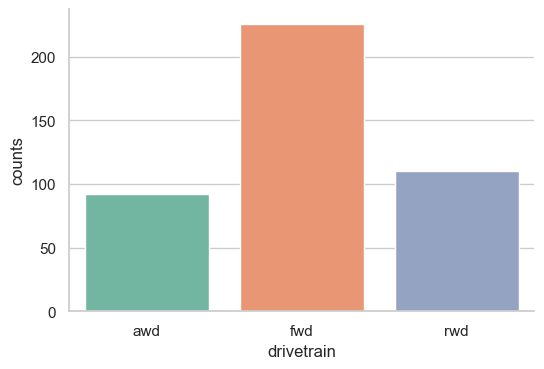

In [230]:
freq = data_drivetrain.groupby(['drivetrain']).size().reset_index(name='counts')
sns.barplot(x="drivetrain", y="counts", data=freq)

## Car Type

In [ ]:
columns = car_dict.loc[car_dict.eval("category == 'car_type'"), "variable"]  #extract all of the drivetrain types from the data dictionary & keep the variable only that becomes columns
data_cartype = extract_subtable(data, columns, label = "Car Type")
data_cartype